## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

### Инструкция по выполнению проекта

1. Загрузим данные и выполните их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделайте выводы.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv')

In [3]:
taxi.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Приведём даты к нужному формату и установим их в качестве индекса.

In [5]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi = taxi.set_index('datetime')
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Отсортируем индекс по возрастанию, разобьем данные на отрезки по одному часу.

In [6]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
print(taxi.index.min(), taxi.index.max())

2018-03-01 00:00:00 2018-08-31 23:00:00


Наш отрезок охватывает данные с 1 марта по 31 августа 2018 года.

# 2. Анализ

Посмотрим на тренд, сезонность и шум в наших данных.

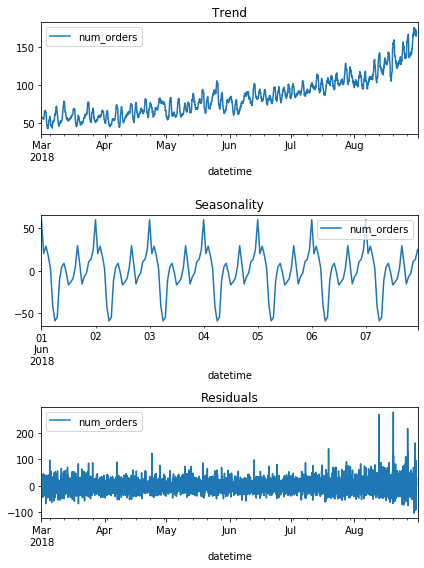

In [8]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
# оценим сезонность в разрезе недели, пусть это будет середина нашего участка - с 1 по 7 июня
decomposed.seasonal['2018-06-01':'2018-06-07'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

#### Выводы:

Тренд свидетельствует о повышении числа заказов от марта к августу.

Сезонность в разрезе буднего дня демонстрирует, что число заказов падает к 6 утра, а в течение дня имеет пики в 10, 16 и 24 часа.    

# 3. Обучение

In [9]:
print("Средний объём заказов в час:", taxi['num_orders'].mean())

Средний объём заказов в час: 84.42278079710145


#### 3.1. Константная модель.

In [10]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

In [11]:
pred_median = np.ones(test.shape) * train['num_orders'].median()
print("RMSE константной модели:", mean_squared_error(pred_median, test)**(1/2))

RMSE константной модели: 87.15277582981295


#### 3.2. Предсказание по предыдущему значению.

In [12]:
pred_prev = test.shift(fill_value=train['num_orders'].iloc[-1])
print("RMSE предсказания по предыдущему значению:", mean_squared_error(pred_prev, test)**(1/2))

RMSE предсказания по предыдущему значению: 58.856486242815066


#### 3.3. Подготовка данных для обучения.

Создадим отдельные признаки месяца, дня в году, дня недели, часа, а также добавим показатели предыдущих значений и скользящего среднего.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

new_taxi = make_features(taxi, 8, 2)

train, test = train_test_split(new_taxi, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)
y_train = train['num_orders']
y_test = test['num_orders']

# 4. Тестирование

#### 4.1. Линейная регрессия

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)
pred_linear = model.predict(X_test)
print("RMSE линейной регрессии:", mean_squared_error(pred_linear, y_test)**(1/2))

RMSE линейной регрессии: 52.6222583175838


#### 4.2. Случайный лес

In [15]:
param_forest = {'max_depth': range(1, 51, 5), 'min_samples_split': range(2, 10), 'min_samples_leaf': range(1, 10)}
time_split = TimeSeriesSplit()
model = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=1), cv=time_split, n_iter=10, param_distributions = param_forest, random_state=1, scoring="neg_mean_squared_error")
model.fit(X_train, y_train)
best_model = model.best_estimator_
pred_rf = best_model.predict(X_test)
print("RMSE случайного леса:", mean_squared_error(pred_rf, y_test)**(1/2))

RMSE случайного леса: 45.57433392774262


#### Выводы:

В ходе работы мы провели ресемплирование данных о количестве заказов такси по одному часу.

Были построены графики тренда, сезонности и шума, демонстрирующие изменение динамики заказов в течение года (увеличение к лету) и суток (наличие нескольких часов пик).

Используя признаки даты, месяца, дня недели, информацию о предыдущем объеме заказов и скользящее среднее, мы сумели построить модели, предсказывающие объем заказов в час значительно лучше, чем константная (RMSE=52 для линейной регрессии и 45 для случайного леса).